# Spectral Temporal Graph Neural Network for Multivariate Time Series Forecasting with applications to cryptocurrency data

Anastasia Yaschenko, Nikita Glukhov 

Data can be accessed here https://www.kaggle.com/datasets/tencars/392-crypto-currency-pairs-at-minute-resolution
Please, see full description there

The paper which the work is based on: https://arxiv.org/pdf/2103.07719.pdf (Neurips 2021)

# Data preprocessing

In [1]:
import gdown
!gdown --id 1HgXmY3zd7gzAHGB3FEyXEzOXO1QGNor6

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1HgXmY3zd7gzAHGB3FEyXEzOXO1QGNor6
To: /content/archive.zip
100% 1.40G/1.40G [00:05<00:00, 251MB/s]


In [2]:
!pip3 install torch==1.7.1 torchvision==0.8.2 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached torch-1.7.1-cp37-cp37m-manylinux1_x86_64.whl (776.8 MB)
  Using cached torchvision-0.8.2-cp37-cp37m-manylinux1_x86_64.whl (12.8 MB)
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0+cu113
    Uninstalling torchvision-0.12.0+cu113:
      Successfully uninstalled torchvision-0.12.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.7.1 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.7.1 which is incompatible.


In [3]:
!unzip -q /content/archive.zip -d /content/data

replace /content/data/1inch-usd.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/data/1inch-ust.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import os

plt.style.use('fivethirtyeight')

In [5]:
name = '/content/data/btcusd.csv'
data = pd.read_csv(name, sep=',')[['time', 'close']]
suffix = name.split('/')[-1][:-7]
data.columns = [name + '_' + suffix if i > 0 else name for i, name in enumerate(data.columns)]
data

,time,close_btc
0,1364774820000,93.300000
1,1364774880000,100.000000
2,1364774940000,93.300000
3,1364775060000,93.470000
4,1364775120000,93.470000
...,...,...
3872540,1653204540000,29364.288088
3872541,1653204600000,29355.000000
3872542,1653204660000,29358.000000
3872543,1653204720000,29367.000000


In [6]:
all_crypto = os.listdir('/content/data') #All available pairs
names = [name for name in all_crypto if ('usd' in name) and ('btc' not in name)]
names

['chzusd.csv',
 'funusd.csv',
 'ringx-usd.csv',
 'jstusd.csv',
 'dgxusd.csv',
 'pasusd.csv',
 'pngusd.csv',
 'lymusd.csv',
 'rrbusd.csv',
 'triusd.csv',
 'odeusd.csv',
 'okbusd.csv',
 'hezusd.csv',
 'band-usd.csv',
 'xrpusd.csv',
 'ocean-usd.csv',
 'stjusd.csv',
 'xmrusd.csv',
 'zilusd.csv',
 'xchusd.csv',
 'mgousd.csv',
 'kaiusd.csv',
 'forth-usd.csv',
 'dtausd.csv',
 'avtusd.csv',
 'wprusd.csv',
 'planets-usd.csv',
 'bmiusd.csv',
 'tsdusd.csv',
 'doge-usd.csv',
 'gmtusd.csv',
 'zbtusd.csv',
 'uosusd.csv',
 'near-usd.csv',
 'bmnusd.csv',
 'utkusd.csv',
 'ustusd.csv',
 'enjusd.csv',
 'apeusd.csv',
 'pnkusd.csv',
 'best-usd.csv',
 'paxusd.csv',
 'sngusd.csv',
 'swmusd.csv',
 'uniusd.csv',
 'zecusd.csv',
 'ancusd.csv',
 'xsnusd.csv',
 'comp-usd.csv',
 'gntusd.csv',
 'poausd.csv',
 'eutusd.csv',
 'requsd.csv',
 'axsusd.csv',
 'ctkusd.csv',
 'gotusd.csv',
 'bchabc-usd.csv',
 'omnusd.csv',
 'dgbusd.csv',
 'waxusd.csv',
 'mimusd.csv',
 'solusd.csv',
 'vetusd.csv',
 'mlnusd.csv',
 'gtxusd.csv

In [7]:
length_dict = {}

for name in names:
  aux_data = pd.read_csv('/content/data/' + name, sep=',')[['time', 'close']]
  length_dict[name] = aux_data.shape[0]

length_dict = sorted(length_dict.items(), key=lambda item: item[1])

In [8]:
names = [i[0] for i in length_dict[-11:]] #chosen cryptocurrencies with the longest history available
names

['zecusd.csv',
 'omgusd.csv',
 'ustusd.csv',
 'leousd.csv',
 'neousd.csv',
 'etcusd.csv',
 'iotusd.csv',
 'eosusd.csv',
 'xrpusd.csv',
 'ltcusd.csv',
 'ethusd.csv']

In [9]:
data_size = 130000 #3 months
data = data.iloc[data_size:, :]

for name in names:
  aux_data = pd.read_csv('/content/data/' + name, sep=',')[['time', 'close']]
  if aux_data.shape[0] >= data_size:
    suffix = name.split('/')[-1].split('.')[0][:-3]
    aux_data.columns = [name + '_' + suffix if i > 0 else name for i, name in enumerate(aux_data.columns)]
    data = data.merge(aux_data.iloc[data_size:, :], how='inner', on = 'time')

data.drop(columns=['time'], inplace = True)
data

,close_btc,close_zec,close_omg,close_ust,close_leo,close_neo,close_etc,close_iot,close_eos,close_xrp,close_ltc,close_eth
0,10247.000000,48.327,1.0732,1.00320,1.1017,9.1500,6.2476,0.25178,4.109600,0.26953,73.491,201.128122
1,10212.000000,48.034,1.0719,1.00330,1.1025,9.1797,6.2799,0.24982,4.091438,0.27300,73.183,199.600000
2,10252.665270,50.330,1.1000,1.00350,1.1093,9.4676,6.3094,0.25998,4.141100,0.29404,74.101,204.610000
3,10268.000000,50.490,1.0994,1.00350,1.1094,9.5077,6.3207,0.26000,4.200100,0.29368,74.480,205.750000
4,10268.429253,50.580,1.1020,1.00350,1.1108,9.5316,6.3324,0.26000,4.239300,0.29418,75.038,207.930000
...,...,...,...,...,...,...,...,...,...,...,...,...
95105,29417.000000,103.320,2.5030,0.99975,4.9373,10.3570,20.3610,0.33372,1.310500,0.41409,70.016,1976.023237
95106,29358.000000,103.320,2.5122,0.99974,4.9350,10.3440,20.3080,0.33497,1.304500,0.41273,69.822,1972.200000
95107,29328.000000,102.990,2.4919,0.99973,4.9393,10.2840,20.2150,0.33221,1.304700,0.41190,69.576,1968.800000
95108,29253.000000,102.420,2.4700,0.99972,4.9399,10.2270,20.1700,0.33117,1.293200,0.41201,69.352,1967.300000


# Visualization

In [10]:
data_normalized = data.iloc[:, :].apply(lambda x: (x-x.mean())/ x.std(), axis=0) #normalize since ranges are very different
data_normalized

,close_btc,close_zec,close_omg,close_ust,close_leo,close_neo,close_etc,close_iot,close_eos,close_xrp,close_ltc,close_eth
0,-2.224506,-1.434682,-1.581018,1.601120,-1.214127,-1.167422,-1.053844,-1.384802,-0.145297,-1.320698,-1.272286,-1.904681
1,-2.227032,-1.439100,-1.581443,1.664799,-1.213541,-1.166384,-1.052701,-1.388145,-0.153398,-1.311896,-1.276388,-1.906057
2,-2.224098,-1.404478,-1.572251,1.792155,-1.208559,-1.156317,-1.051656,-1.370818,-0.131248,-1.258530,-1.264162,-1.901546
3,-2.222991,-1.402065,-1.572447,1.792155,-1.208486,-1.154915,-1.051256,-1.370784,-0.104934,-1.259444,-1.259114,-1.900520
4,-2.222960,-1.400708,-1.571596,1.792155,-1.207460,-1.154079,-1.050842,-1.370784,-0.087451,-1.258175,-1.251683,-1.898557
...,...,...,...,...,...,...,...,...,...,...,...,...
95105,-0.840951,-0.605425,-1.113296,-0.595780,1.595923,-1.125218,-0.554210,-1.245062,-1.393705,-0.954035,-1.318567,-0.306504
95106,-0.845209,-0.605425,-1.110286,-0.602148,1.594238,-1.125672,-0.556086,-1.242931,-1.396381,-0.957485,-1.321151,-0.309946
95107,-0.847374,-0.610401,-1.116927,-0.608516,1.597388,-1.127770,-0.559378,-1.247637,-1.396291,-0.959590,-1.324427,-0.313008
95108,-0.852787,-0.618997,-1.124091,-0.614884,1.597828,-1.129763,-0.560971,-1.249411,-1.401420,-0.959311,-1.327410,-0.314359


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


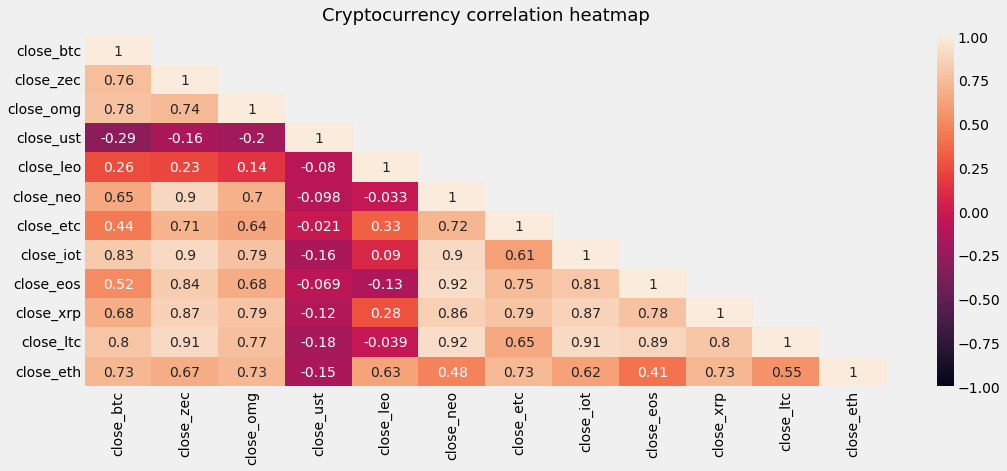

In [11]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(data_normalized.corr().where(np.tril(np.ones(data_normalized.corr().shape)).astype(np.bool)), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Cryptocurrency correlation heatmap', fontdict={'fontsize':18}, pad=16);

In [12]:
data.describe() #statistics

,close_btc,close_zec,close_omg,close_ust,close_leo,close_neo,close_etc,close_iot,close_eos,close_xrp,close_ltc,close_eth
count,95110.000000,95110.000000,95110.000000,95110.000000,95110.000000,95110.000000,95110.000000,95110.000000,95110.000000,95110.000000,95110.000000,95110.000000
mean,41068.879606,143.469395,5.906282,1.000686,2.758932,42.536709,36.016002,1.063792,4.435377,0.790227,169.020721,2316.418616
std,13855.603821,66.316027,3.056944,0.001570,1.364958,28.598656,28.247438,0.586374,2.242137,0.394259,75.085099,1110.574440
min,4030.100000,18.278000,0.321970,0.995100,0.812590,4.087900,3.302000,0.077751,1.104300,0.112550,24.851000,91.246465
25%,34921.102311,96.886750,3.875225,1.000100,1.478900,20.750250,11.500000,0.605325,2.777786,0.498107,114.200000,1706.625000
50%,42089.000000,134.120000,5.285000,1.000500,2.500200,37.192500,30.505000,1.052100,3.917900,0.739645,163.700000,2379.900000
75%,50561.000000,171.800000,7.447925,1.001000,3.417675,53.521000,53.000000,1.384000,5.315375,1.068300,207.380000,3127.470079
max,68735.000000,370.280000,19.820000,1.060000,7.990000,140.360000,158.760000,2.631700,14.840000,1.950600,411.890000,4860.338609


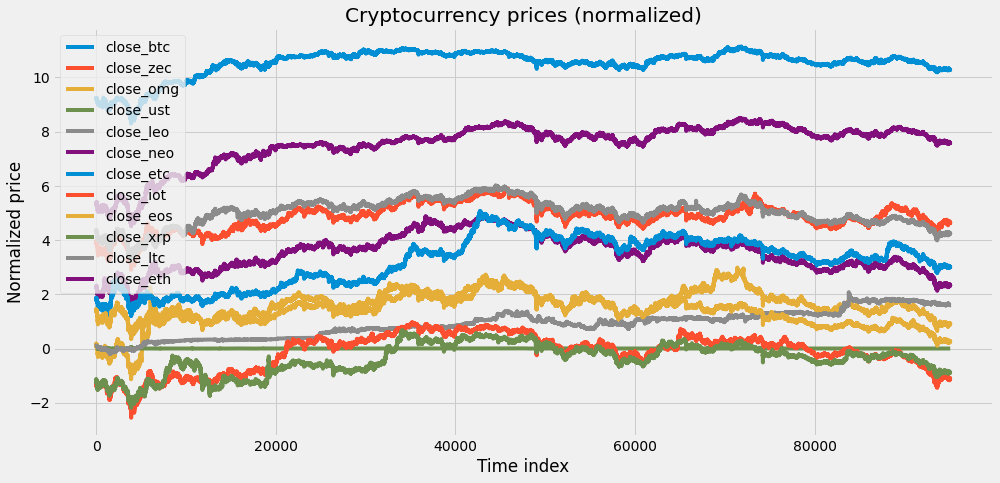

In [13]:
plt.figure(figsize=(15, 7))
for i in data_normalized.columns:
  plt.plot(np.log(data)[i], label = i)
plt.legend()
plt.title('Cryptocurrency prices (normalized)')
plt.xlabel('Time index')
plt.ylabel('Normalized price');

In [14]:
data_arr = data.values

# Training the model

In [15]:
train_data = data_arr[:round(len(data_arr)*0.80), :]
valid_data = data_arr[round(len(data_arr)*0.80):round(len(data_arr)*0.90), :]
test_data = data_arr[round(len(data_arr)*0.90):, :]

In [16]:
!git clone https://github.com/microsoft/StemGNN.git

Cloning into 'StemGNN'...
remote: Enumerating objects: 468, done.
remote: Total 468 (delta 0), reused 0 (delta 0), pack-reused 468
Receiving objects: 100% (468/468), 14.55 MiB | 18.42 MiB/s, done.
Resolving deltas: 100% (250/250), done.


In [17]:
%cd /content/StemGNN

/content/StemGNN


In [18]:
import os
import torch
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from datetime import datetime
from models.handler import train, test
import argparse
from data_loader.forecast_dataloader import ForecastDataset, de_normalized
from models.base_model import Model
from utils.math_utils import evaluate
import time

In [19]:
parser = argparse.ArgumentParser()
parser.add_argument('--train', type=bool, default=True)
parser.add_argument('--evaluate', type=bool, default=True)
parser.add_argument('--dataset', type=str, default='ECG_data')
parser.add_argument('--window_size', type=int, default=8)
parser.add_argument('--horizon', type=int, default=3)
#parser.add_argument('--train_length', type=float, default=7)
#parser.add_argument('--valid_length', type=float, default=2)
#parser.add_argument('--test_length', type=float, default=1)
parser.add_argument('--epoch', type=int, default=50)
parser.add_argument('--lr', type=float, default=1e-4)
parser.add_argument('--multi_layer', type=int, default=5)
parser.add_argument('--device', type=str, default= 'cuda' if torch.cuda.is_available() else 'cpu')
parser.add_argument('--validate_freq', type=int, default=1)
parser.add_argument('--batch_size', type=int, default=32)
parser.add_argument('--norm_method', type=str, default='z_score')
parser.add_argument('--optimizer', type=str, default='Adam')
parser.add_argument('--early_stop', type=bool, default=False)
parser.add_argument('--exponential_decay_step', type=int, default=5)
parser.add_argument('--decay_rate', type=float, default=0.5)
parser.add_argument('--dropout_rate', type=float, default=0.5)
parser.add_argument('--leakyrelu_rate', type=int, default=0.2)
parser.add_argument('-f')

_StoreAction(option_strings=['-f'], dest='f', nargs=None, const=None, default=None, type=None, choices=None, help=None, metavar=None)

In [20]:
args = parser.parse_args()

In [21]:
def inference(model, dataloader, device, node_cnt, window_size, horizon):
    forecast_set = []
    target_set = []
    model.eval()
    with torch.no_grad():
        for i, (inputs, target) in enumerate(dataloader):
            inputs = inputs.to(device)
            target = target.to(device)
            step = 0
            forecast_steps = np.zeros([inputs.size()[0], horizon, node_cnt], dtype=np.float)
            while step < horizon:
                forecast_result, a = model(inputs)
                len_model_output = forecast_result.size()[1]
                if len_model_output == 0:
                    raise Exception('Get blank inference result')
                inputs[:, :window_size - len_model_output, :] = inputs[:, len_model_output:window_size,
                                                                   :].clone()
                inputs[:, window_size - len_model_output:, :] = forecast_result.clone()
                forecast_steps[:, step:min(horizon - step, len_model_output) + step, :] = \
                    forecast_result[:, :min(horizon - step, len_model_output), :].detach().cpu().numpy()
                step += min(horizon - step, len_model_output)
            forecast_set.append(forecast_steps)
            target_set.append(target.detach().cpu().numpy())
    return np.concatenate(forecast_set, axis=0), np.concatenate(target_set, axis=0)

In [22]:
def validate(model, dataloader, device, normalize_method, statistic,
             node_cnt, window_size, horizon,
             result_file=None):
    start = datetime.now()
    forecast_norm, target_norm = inference(model, dataloader, device,
                                           node_cnt, window_size, horizon)
    if normalize_method and statistic:
        forecast = de_normalized(forecast_norm, normalize_method, statistic)
        target = de_normalized(target_norm, normalize_method, statistic)
    else:
        forecast, target = forecast_norm, target_norm
    score = evaluate(target, forecast)
    score_by_node = evaluate(target, forecast, by_node=True)
    end = datetime.now()

    score_norm = evaluate(target_norm, forecast_norm)
    print(f'NORM: MAPE {score_norm[0]:7.9%}; MAE {score_norm[1]:7.9f}; RMSE {score_norm[2]:7.9f}.')
    print(f'RAW : MAPE {score[0]:7.9%}; MAE {score[1]:7.9f}; RMSE {score[2]:7.9f}.')
    if result_file:
        if not os.path.exists(result_file):
            os.makedirs(result_file)
        step_to_print = 0
        forcasting_2d = forecast[:, step_to_print, :]
        forcasting_2d_target = target[:, step_to_print, :]

        np.savetxt(f'{result_file}/target.csv', forcasting_2d_target, delimiter=",")
        np.savetxt(f'{result_file}/predict.csv', forcasting_2d, delimiter=",")
        np.savetxt(f'{result_file}/predict_abs_error.csv',
                   np.abs(forcasting_2d - forcasting_2d_target), delimiter=",")
        np.savetxt(f'{result_file}/predict_ape.csv',
                   np.abs((forcasting_2d - forcasting_2d_target) / forcasting_2d_target), delimiter=",")

    return dict(mae=score[1], mae_node=score_by_node[1], mape=score[0], mape_node=score_by_node[0],
                rmse=score[2], rmse_node=score_by_node[2])

In [23]:
node_cnt = train_data.shape[1]
model = Model(node_cnt, 2, args.window_size, args.multi_layer, horizon=args.horizon)
model.to(args.device)

Model(
  (GRU): GRU(8, 12)
  (stock_block): ModuleList(
    (0): StockBlockLayer(
      (forecast): Linear(in_features=40, out_features=40, bias=True)
      (forecast_result): Linear(in_features=40, out_features=8, bias=True)
      (backcast): Linear(in_features=40, out_features=8, bias=True)
      (backcast_short_cut): Linear(in_features=8, out_features=8, bias=True)
      (relu): ReLU()
      (GLUs): ModuleList(
        (0): GLU(
          (linear_left): Linear(in_features=32, out_features=160, bias=True)
          (linear_right): Linear(in_features=32, out_features=160, bias=True)
        )
        (1): GLU(
          (linear_left): Linear(in_features=32, out_features=160, bias=True)
          (linear_right): Linear(in_features=32, out_features=160, bias=True)
        )
        (2): GLU(
          (linear_left): Linear(in_features=160, out_features=160, bias=True)
          (linear_right): Linear(in_features=160, out_features=160, bias=True)
        )
        (3): GLU(
          (li

In [24]:
if args.norm_method == 'z_score':
    train_mean = np.mean(train_data, axis=0)
    train_std = np.std(train_data, axis=0)
    normalize_statistic = {"mean": train_mean.tolist(), "std": train_std.tolist()}
elif args.norm_method == 'min_max':
    train_min = np.min(train_data, axis=0)
    train_max = np.max(train_data, axis=0)
    normalize_statistic = {"min": train_min.tolist(), "max": train_max.tolist()}
else:
    normalize_statistic = None
#if normalize_statistic is not None:
#    with open(os.path.join(result_file, 'norm_stat.json'), 'w') as f:
#        json.dump(normalize_statistic, f)

if args.optimizer == 'RMSProp':
    my_optim = torch.optim.RMSprop(params=model.parameters(), lr=args.lr, eps=1e-08)
else:
    my_optim = torch.optim.Adam(params=model.parameters(), lr=args.lr, betas=(0.9, 0.999))

my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=my_optim, gamma=args.decay_rate)

train_set = ForecastDataset(train_data, window_size=args.window_size, horizon=args.horizon,
                            normalize_method=args.norm_method, norm_statistic=normalize_statistic)
valid_set = ForecastDataset(valid_data, window_size=args.window_size, horizon=args.horizon,
                            normalize_method=args.norm_method, norm_statistic=normalize_statistic)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=args.batch_size, drop_last=False, shuffle=True,
                                      num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=args.batch_size, shuffle=False, num_workers=0)

forecast_loss = nn.MSELoss(reduction='mean').to(args.device)

In [25]:
total_params = 0
for name, parameter in model.named_parameters():
    if not parameter.requires_grad: continue
    param = parameter.numel()
    total_params += param
print(f"Total Trainable Params: {total_params}")

Total Trainable Params: 472523


In [ ]:
#for g in my_optim.param_groups:
#    g['lr'] = g['lr'] /  10

Do not run the next cell unless you wish to train

In [ ]:
mape_list = []
mae_list = []
rmse_list = []
best_validate_mae = np.inf
validate_score_non_decrease_count = 0
performance_metrics = {}
for epoch in range(args.epoch):
    epoch_start_time = time.time()
    model.train()
    loss_total = 0
    cnt = 0
    for i, (inputs, target) in enumerate(train_loader):
        inputs = inputs.to(args.device)
        target = target.to(args.device)
        model.zero_grad()
        forecast, _ = model(inputs)
        loss = forecast_loss(forecast, target)
        cnt += 1
        loss.backward()
        my_optim.step()
        loss_total += float(loss)
        
    print('| end of epoch {:3d} | time: {:5.2f}s | train_total_loss {:5.4f}'.format(epoch, (
            time.time() - epoch_start_time), loss_total / cnt))
    torch.save(model, 'GNN.pt')
    wandb.log({"train_loss": loss_total / cnt})
    if (epoch+1) % args.exponential_decay_step == 0:
        my_lr_scheduler.step()
    if (epoch + 1) % args.validate_freq == 0:
        is_best_for_now = False
        print('------ validate on data: VALIDATE ------')
        performance_metrics = \
            validate(model, valid_loader, args.device, args.norm_method, normalize_statistic,
                      node_cnt, args.window_size, args.horizon)
       # mae_list.append(performance_metrics['mae'])
       # rmse_list.append(performance_metrics['rmse'])
       # mape_list.append(performance_metrics['mape'])
        wandb.log({"MAE": performance_metrics['mae']})
        wandb.log({"RMSE": performance_metrics['rmse']})
        wandb.log({"MAPE": performance_metrics['mape']})
        if best_validate_mae > performance_metrics['mae']:
            best_validate_mae = performance_metrics['mae']
            is_best_for_now = True
            validate_score_non_decrease_count = 0
        else:
            validate_score_non_decrease_count += 1
        # save model
        if is_best_for_now:
            torch.save(model, 'GNN.pt')
    # early stop
    if args.early_stop and validate_score_non_decrease_count >= args.early_stop_step:
        break


| end of epoch   0 | time: 65.20s | train_total_loss 0.2079
------ validate on data: VALIDATE ------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


NORM: MAPE 38.533246640%; MAE 0.082259167; RMSE 0.221116208.
RAW : MAPE 3.952311594%; MAE 79.628300311; RMSE 300.879169281.
| end of epoch   1 | time: 48.73s | train_total_loss 0.0288
------ validate on data: VALIDATE ------
NORM: MAPE 34.811281251%; MAE 0.069522032; RMSE 0.107914387.
RAW : MAPE 4.105920192%; MAE 84.820765741; RMSE 301.490985968.
| end of epoch   2 | time: 50.91s | train_total_loss 0.0217
------ validate on data: VALIDATE ------
NORM: MAPE 28.773104952%; MAE 0.045416634; RMSE 0.077886182.
RAW : MAPE 2.235296049%; MAE 78.971262407; RMSE 291.277711679.
| end of epoch   3 | time: 48.85s | train_total_loss 0.0175
------ validate on data: VALIDATE ------
NORM: MAPE 24.445354599%; MAE 0.049743110; RMSE 0.119005663.
RAW : MAPE 2.473726440%; MAE 44.167241724; RMSE 173.004825691.
| end of epoch   4 | time: 48.82s | train_total_loss 0.0147
------ validate on data: VALIDATE ------
NORM: MAPE 25.476881808%; MAE 0.043227258; RMSE 0.079285401.
RAW : MAPE 2.266899704%; MAE 62.4242771

KeyboardInterrupt: ignored

# Graph visualisation

In [26]:
!gdown 1tkJnOlBXUb_KgxPdJwGv11R84HnOAYhE #download checkpoint

Downloading...
From: https://drive.google.com/uc?id=1tkJnOlBXUb_KgxPdJwGv11R84HnOAYhE
To: /content/StemGNN/GNN.pt
100% 1.92M/1.92M [00:00<00:00, 161MB/s]


In [27]:
model = torch.load('GNN.pt', map_location = 'cpu')
model = model.to(args.device)

In [28]:
model.eval()

if args.norm_method == 'z_score':
    train_mean = np.mean(train_data, axis=0)
    train_std = np.std(train_data, axis=0)
    normalize_statistic = {"mean": train_mean.tolist(), "std": train_std.tolist()}
elif args.norm_method == 'min_max':
    train_min = np.min(train_data, axis=0)
    train_max = np.max(train_data, axis=0)
    normalize_statistic = {"min": train_min.tolist(), "max": train_max.tolist()}
else:
    normalize_statistic = None
    
test_set = ForecastDataset(test_data, window_size=args.window_size, horizon=args.horizon,
                            normalize_method=args.norm_method, norm_statistic=normalize_statistic)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=len(test_set), shuffle=False, num_workers=0)

inputs, targets = next(iter(test_loader))
inputs = inputs.to(args.device)
targets = targets.to(args.device)
mu_L, W = model.latent_correlation_layer(inputs)

In [29]:
W = W.detach().cpu().numpy() #get adjacency matrix

In [30]:
import networkx as nx

In [31]:
def draw_network(network):
    plt.figure(figsize = (20, 15))
    edges,weights = zip(*nx.get_edge_attributes(network,'weight').items())
    d = dict(network.degree)
    nx.draw(network,edgelist=edges, edge_color=weights, font_size = 25, font_color = 'r', with_labels=True,edge_cmap=plt.cm.Greens, width=7,node_size=[v * 100 for v in d.values()], node_color = 'b')
    plt.show()

<Figure size 1224x864 with 0 Axes>

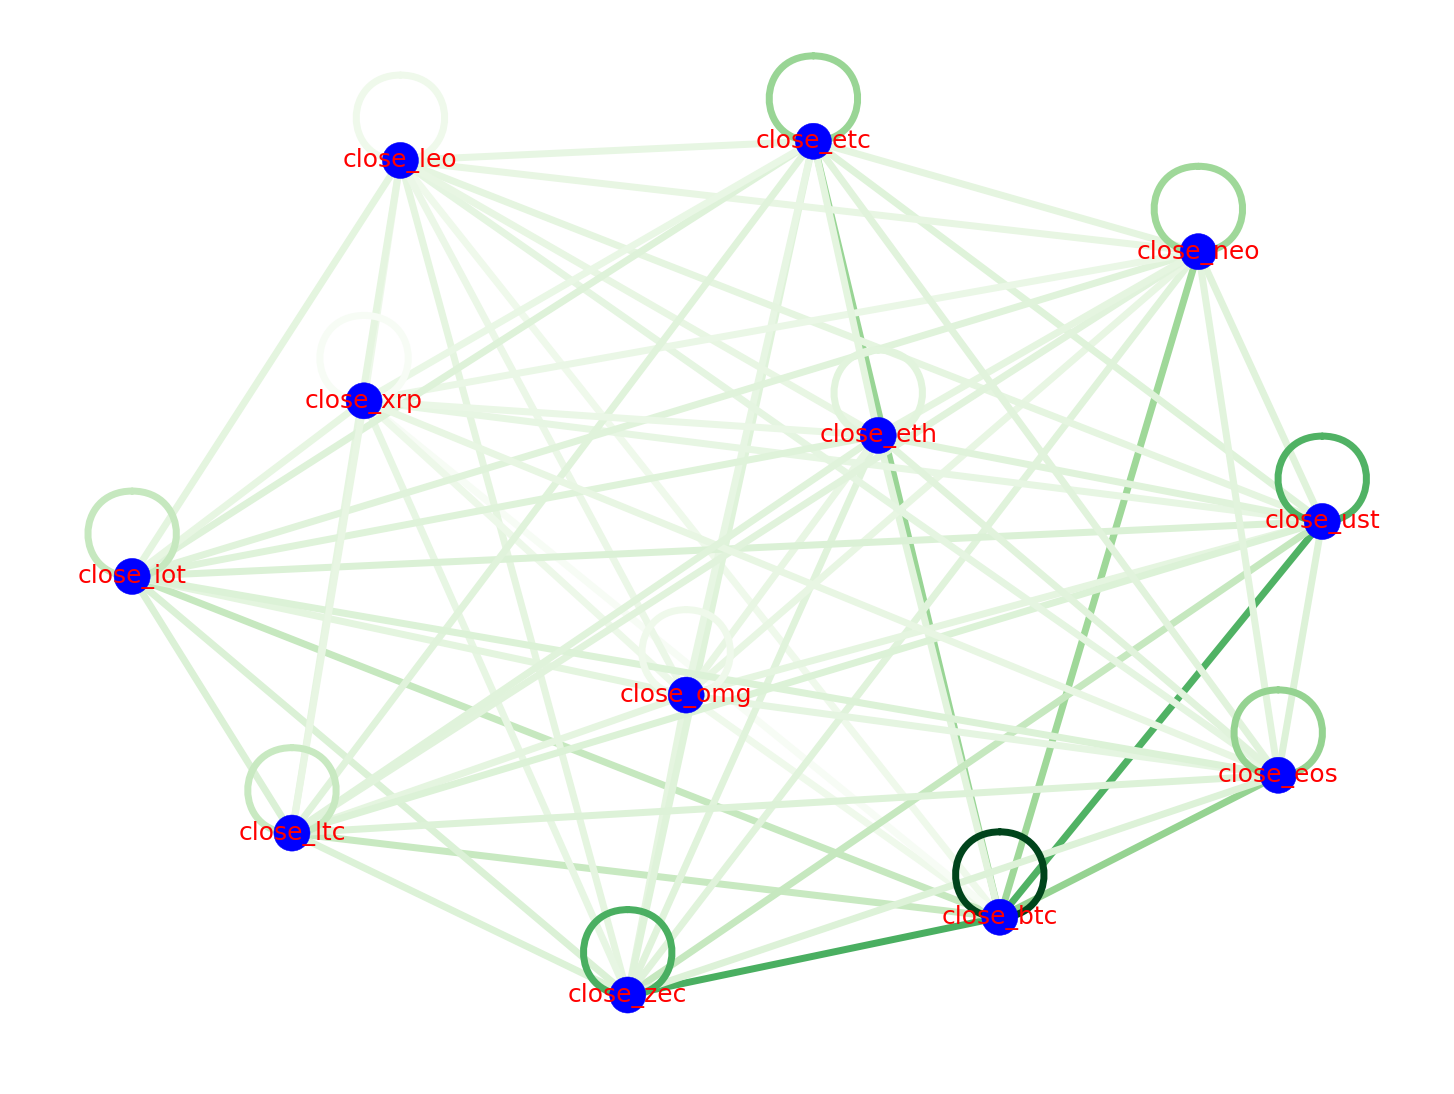

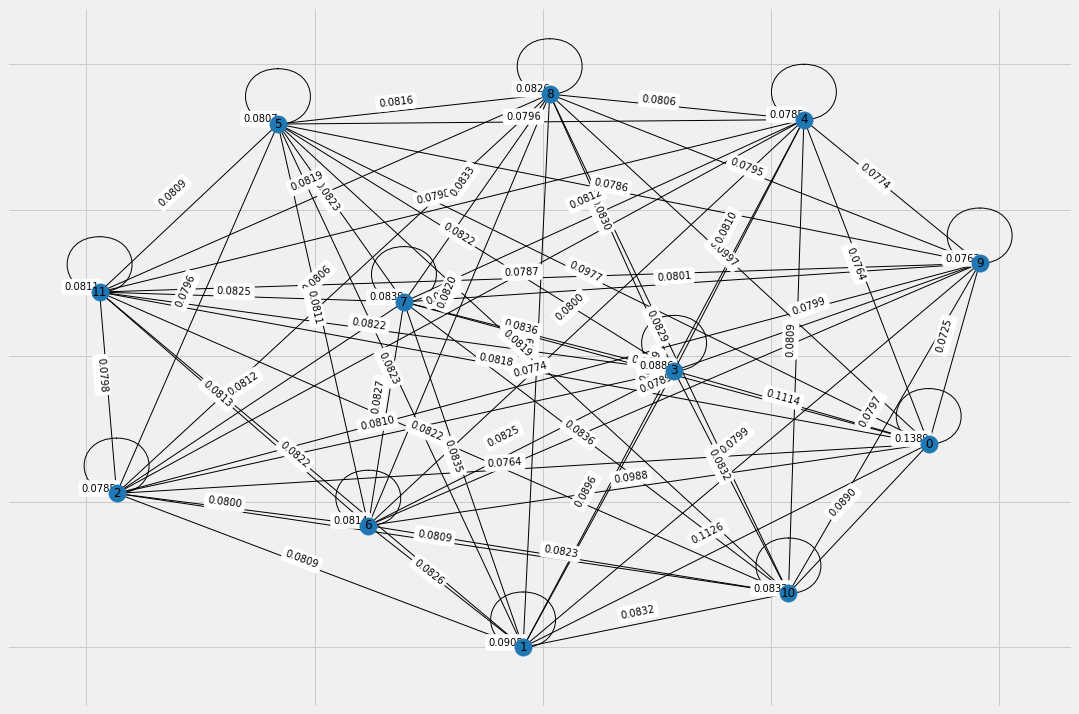

In [32]:
G = nx.from_numpy_matrix(W)
plt.figure(figsize=(17, 12))
coord=nx.spring_layout(G)
#nx.draw_networkx(G,coord)
labels = data_normalized.columns.values
G = nx.relabel_nodes(G, dict(zip(range(len(labels)), labels)))
draw_network(G)

G = nx.from_numpy_matrix(W)
plt.figure(figsize=(17, 12))
coord=nx.spring_layout(G)
nx.draw_networkx(G,coord)
labels = dict([((u,v,), f"{d['weight']:.4f}") for u,v,d in G.edges(data=True)])
nx.draw_networkx_edge_labels(G,coord,edge_labels=labels, verticalalignment = 'bottom', horizontalalignment = 'right');

## Statistics

In [33]:
print('Avg shortest path length: {}'.format(nx.average_shortest_path_length(G)))
print('Diameter: {}'.format(nx.diameter(G)))
print('Eccentricity: {}'.format(nx.eccentricity(G)))
print('Periphery: {}'.format(nx.periphery(G)))
print('Center: {}'.format(nx.center(G)))
print('Clustering: {}'.format(nx.clustering(G)))
print('Transitivity: {}'.format(nx.transitivity(G)))


Avg shortest path length: 1.0
Diameter: 1
Eccentricity: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1}
Periphery: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Center: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Clustering: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0}
Transitivity: 1.0


In [34]:
print('Degree centrality: {}'.format(nx.degree_centrality(G)))
print('Closeness centarlity: {}'.format(nx.closeness_centrality(G)))
print('Betweness centarlity: {}'.format(nx.betweenness_centrality(G)))
print('Eigenvector centarlity: {}'.format(nx.eigenvector_centrality(G)))


Degree centrality: {0: 1.1818181818181819, 1: 1.1818181818181819, 2: 1.1818181818181819, 3: 1.1818181818181819, 4: 1.1818181818181819, 5: 1.1818181818181819, 6: 1.1818181818181819, 7: 1.1818181818181819, 8: 1.1818181818181819, 9: 1.1818181818181819, 10: 1.1818181818181819, 11: 1.1818181818181819}
Closeness centarlity: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0}
Betweness centarlity: {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0}
Eigenvector centarlity: {0: 0.2886751345948129, 1: 0.2886751345948129, 2: 0.2886751345948129, 3: 0.2886751345948129, 4: 0.2886751345948129, 5: 0.2886751345948129, 6: 0.2886751345948129, 7: 0.2886751345948129, 8: 0.2886751345948129, 9: 0.2886751345948129, 10: 0.2886751345948129, 11: 0.2886751345948129}


In [35]:
connected_component_subgraphs = (G.subgraph(c) for c in nx.connected_components(G))

Gc = max(connected_component_subgraphs, key=len)

print("Number of nodes in largest connected component {}".format(len(Gc.nodes())))
print("Number of edges in largest connected component {}".format(Gc.edges()))

Number of nodes in largest connected component 12
Number of edges in largest connected component [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (7, 7), (7, 8), (7, 9), (7, 10), (7, 11), (8, 8), (8, 9), (8, 10), (8, 11), (9, 9), (9, 10), (9, 11), (10, 10), (10, 11), (11, 11)]


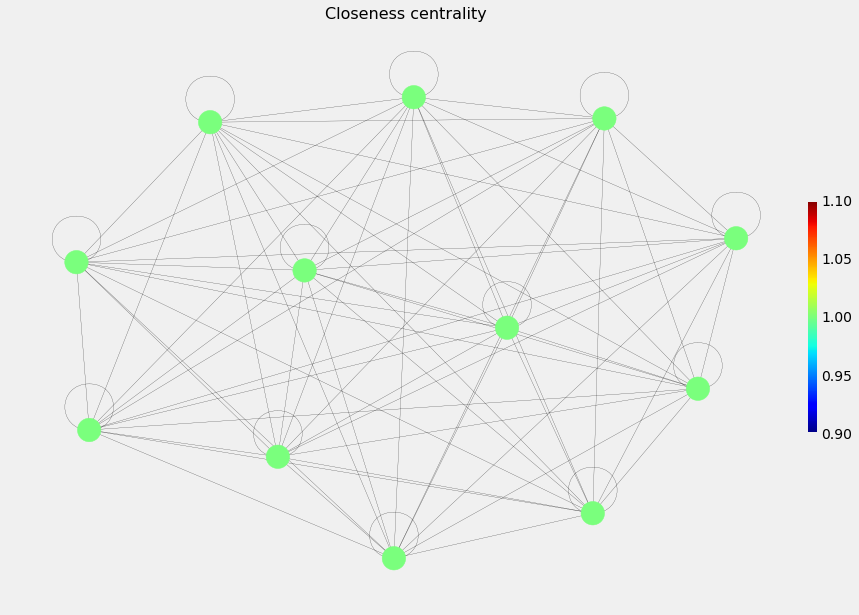

In [36]:
plt.figure(figsize=(15, 10))
closeness_centr = nx.closeness_centrality(Gc)
node_colors = list(closeness_centr.values())

nodes = nx.draw_networkx_nodes(Gc, pos = coord, 
                               node_color=node_colors,
                               node_size = 550,
                               nodelist=list(closeness_centr.keys()),
                               cmap = 'jet')
edges = nx.draw_networkx_edges(Gc, pos = coord, width = .2)
#plt.xlim([-2, 2])
#plt.ylim([-2, 2])
plt.colorbar(nodes, shrink=.4, pad=.0005, aspect=20)
plt.title('Closeness centrality', fontsize = 16)
plt.axis("off")

top_nodes = sorted(closeness_centr, key = closeness_centr.get)[-3:]


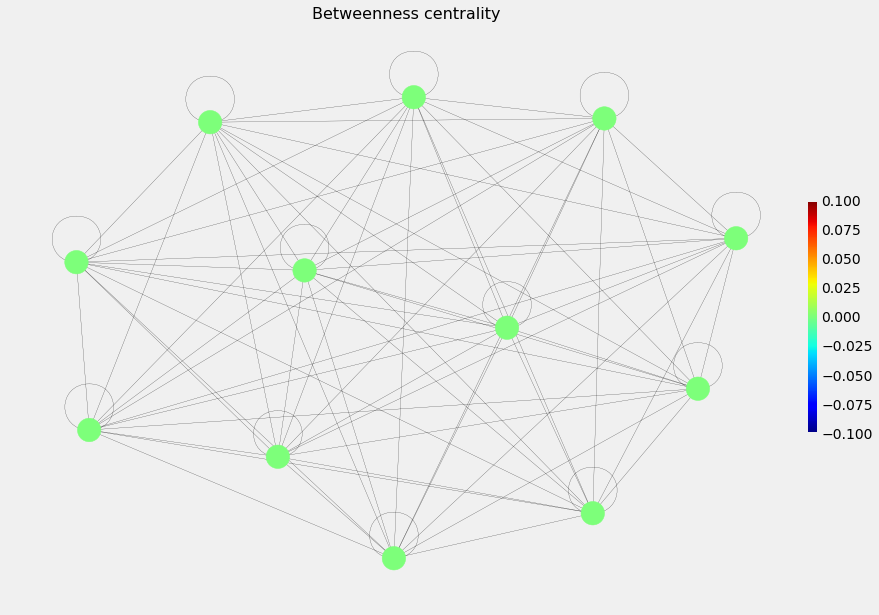

In [37]:
plt.figure(figsize=(15, 10))
between_centr = nx.betweenness_centrality(Gc)
node_colors = list(between_centr.values())

nodes = nx.draw_networkx_nodes(Gc, pos = coord, 
                               node_color=node_colors,
                               node_size = 550,
                               nodelist=list(between_centr.keys()),
                               cmap = 'jet')
edges = nx.draw_networkx_edges(Gc, pos = coord, width = .2)
##plt.xlim([-.95, .9])
#plt.ylim([-.5, .6])
plt.colorbar(nodes, shrink=.4, pad=.0005, aspect=20)
plt.title('Betweenness centrality', fontsize = 16)
plt.axis("off")

top_nodes = sorted(between_centr, key = between_centr.get)[-5:]


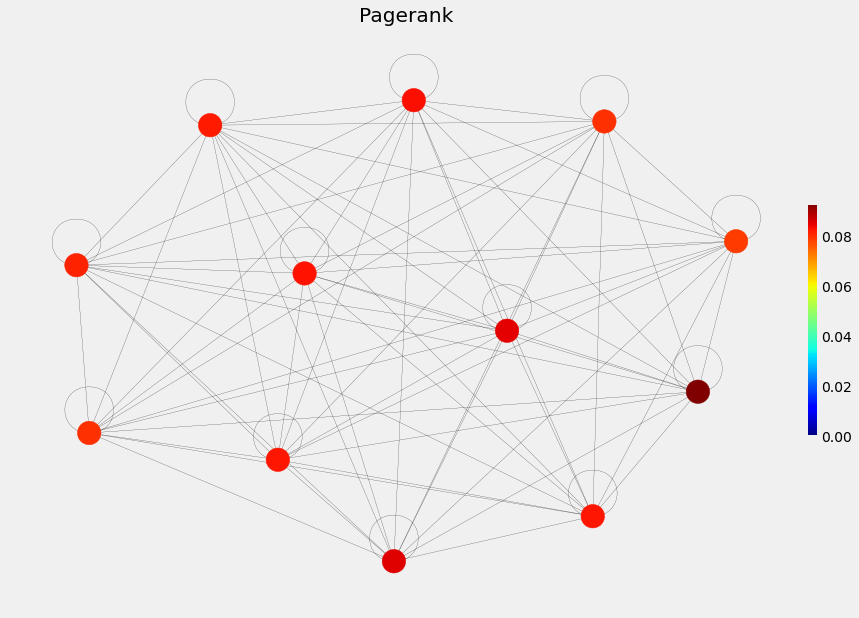

In [38]:
plt.figure(figsize=(15, 10))
page_rank = nx.pagerank(Gc)
node_colors = list(page_rank.values())

nodes = nx.draw_networkx_nodes(Gc, pos = coord, 
                               node_color=node_colors,
                               node_size = 550,
                               nodelist=list(page_rank.keys()),
                               cmap = 'jet',
                               vmin = 0.0)
edges = nx.draw_networkx_edges(Gc, pos = coord, width = .2)
#plt.xlim([-.95, .9])
#plt.ylim([-.5, .6])
plt.colorbar(nodes, shrink=.4, pad=.0005, aspect=20)
plt.title('Pagerank')
plt.axis("off")

top_nodes = sorted(page_rank, key = page_rank.get)[-3:]



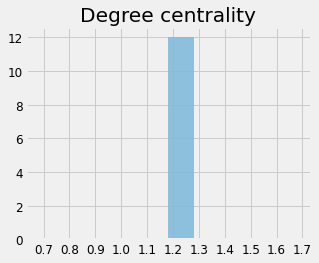

In [39]:
def plot_hist(data, colormap, alpha, bins = 10, round_value = 1):
    cm = plt.cm.get_cmap(colormap)
    counts, bins, patches = plt.hist(data, alpha = alpha, color = 'Blue', bins = bins)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    plt.xticks(bins.round(round_value))
    col = bin_centers - min(bin_centers)
    col /= max(col)
    # use various colors for different bins:
    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cm(c))
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)

plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.title("Degree centrality", y = 1.00)
plot_hist(data = list(nx.degree_centrality(G).values()), colormap = 'Blues_r', alpha = 0.9, bins = 10)



#Filtering

In [40]:
tree=nx.minimum_spanning_tree(G)

Minimum spanning tree


<Figure size 1224x864 with 0 Axes>

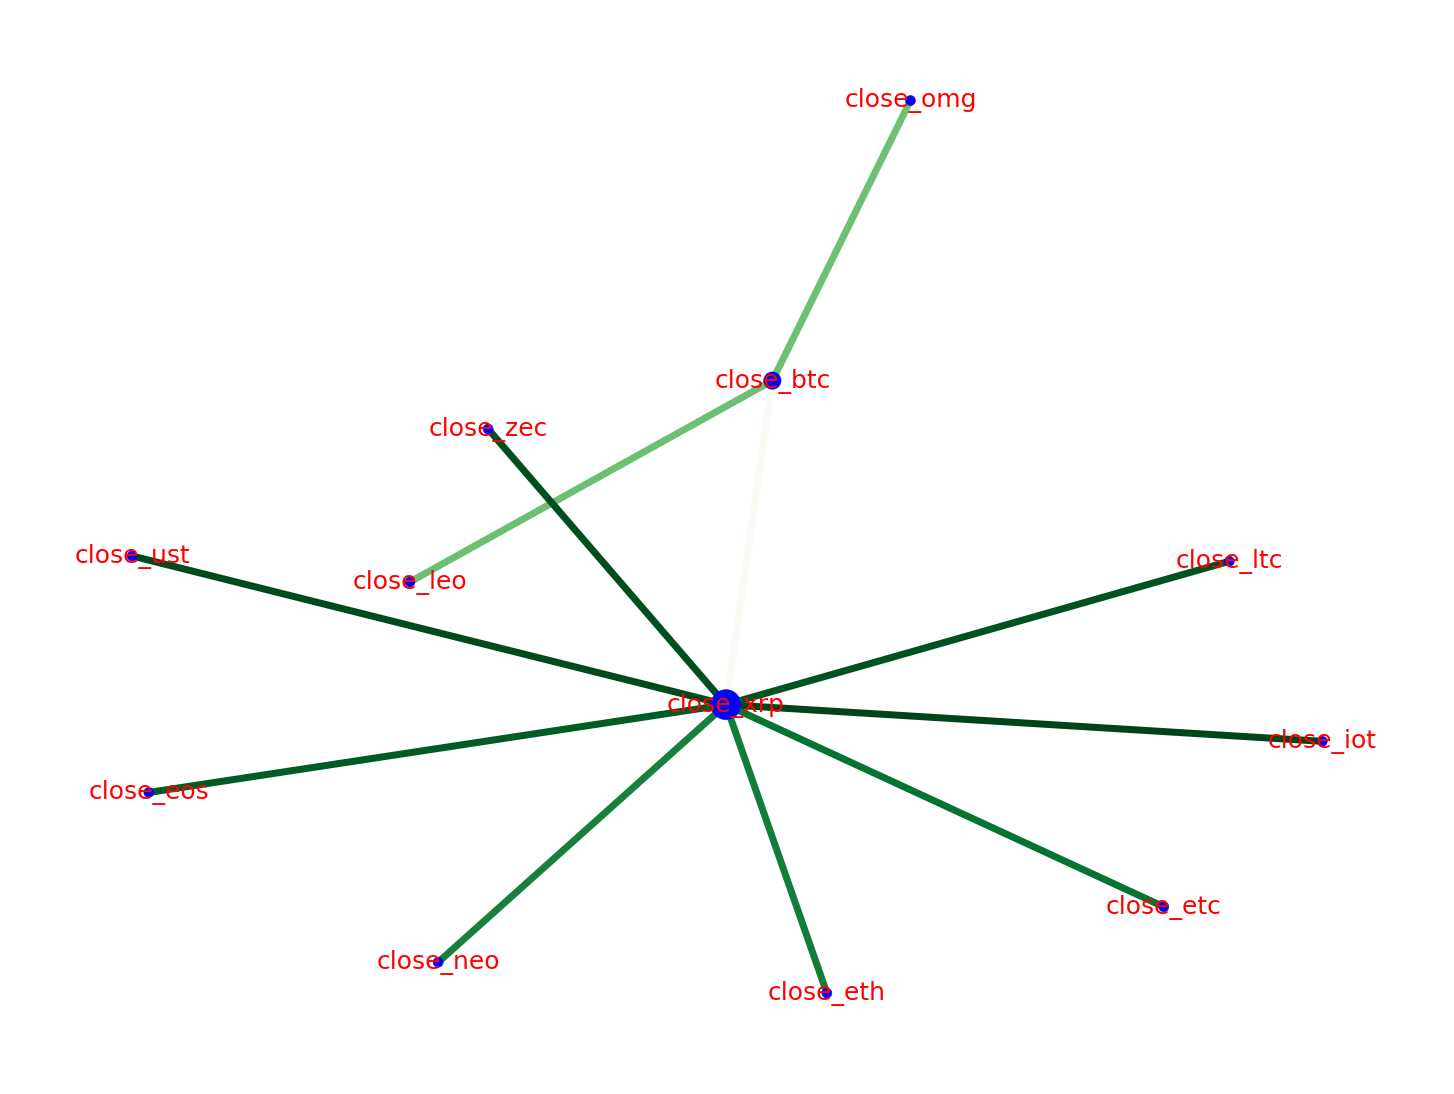

In [41]:
plt.figure(figsize=(17, 12))
coord=nx.spring_layout(tree)
labels = data_normalized.columns.values
tree = nx.relabel_nodes(tree, dict(zip(range(len(labels)), labels)))
print('Minimum spanning tree')
draw_network(tree)

In [42]:
!git clone https://github.com/DerwenAI/disparity_filter.git #disparity filter
from disparity_filter.disparity import disparity_filter, calc_alpha_ptile, cut_graph
G_copy = G.copy()

Cloning into 'disparity_filter'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 71 (delta 2), reused 6 (delta 1), pack-reused 58
Unpacking objects: 100% (71/71), done.


In [43]:
min_alpha_ptile = 0.05
min_degree = 2
alpha_measures = disparity_filter(G_copy)
quantiles, num_quant = calc_alpha_ptile(alpha_measures)
alpha_cutoff = quantiles[round(num_quant * min_alpha_ptile)]
print("\nfilter: percentile {:0.2f}, min alpha {:0.4f}, min degree {}".format(
        min_alpha_ptile, alpha_cutoff, min_degree
        ))
cut_graph(G_copy, min_alpha_ptile, min_degree)

	ptile	alpha
	0.00	0.2118
	0.10	0.3429
	0.20	0.3469
	0.30	0.3500
	0.40	0.3530
	0.50	0.3558
	0.60	0.3600
	0.70	0.3650
	0.80	0.3692
	0.90	0.4560

filter: percentile 0.05, min alpha 0.2118, min degree 2


Disparity filter


<Figure size 1224x864 with 0 Axes>

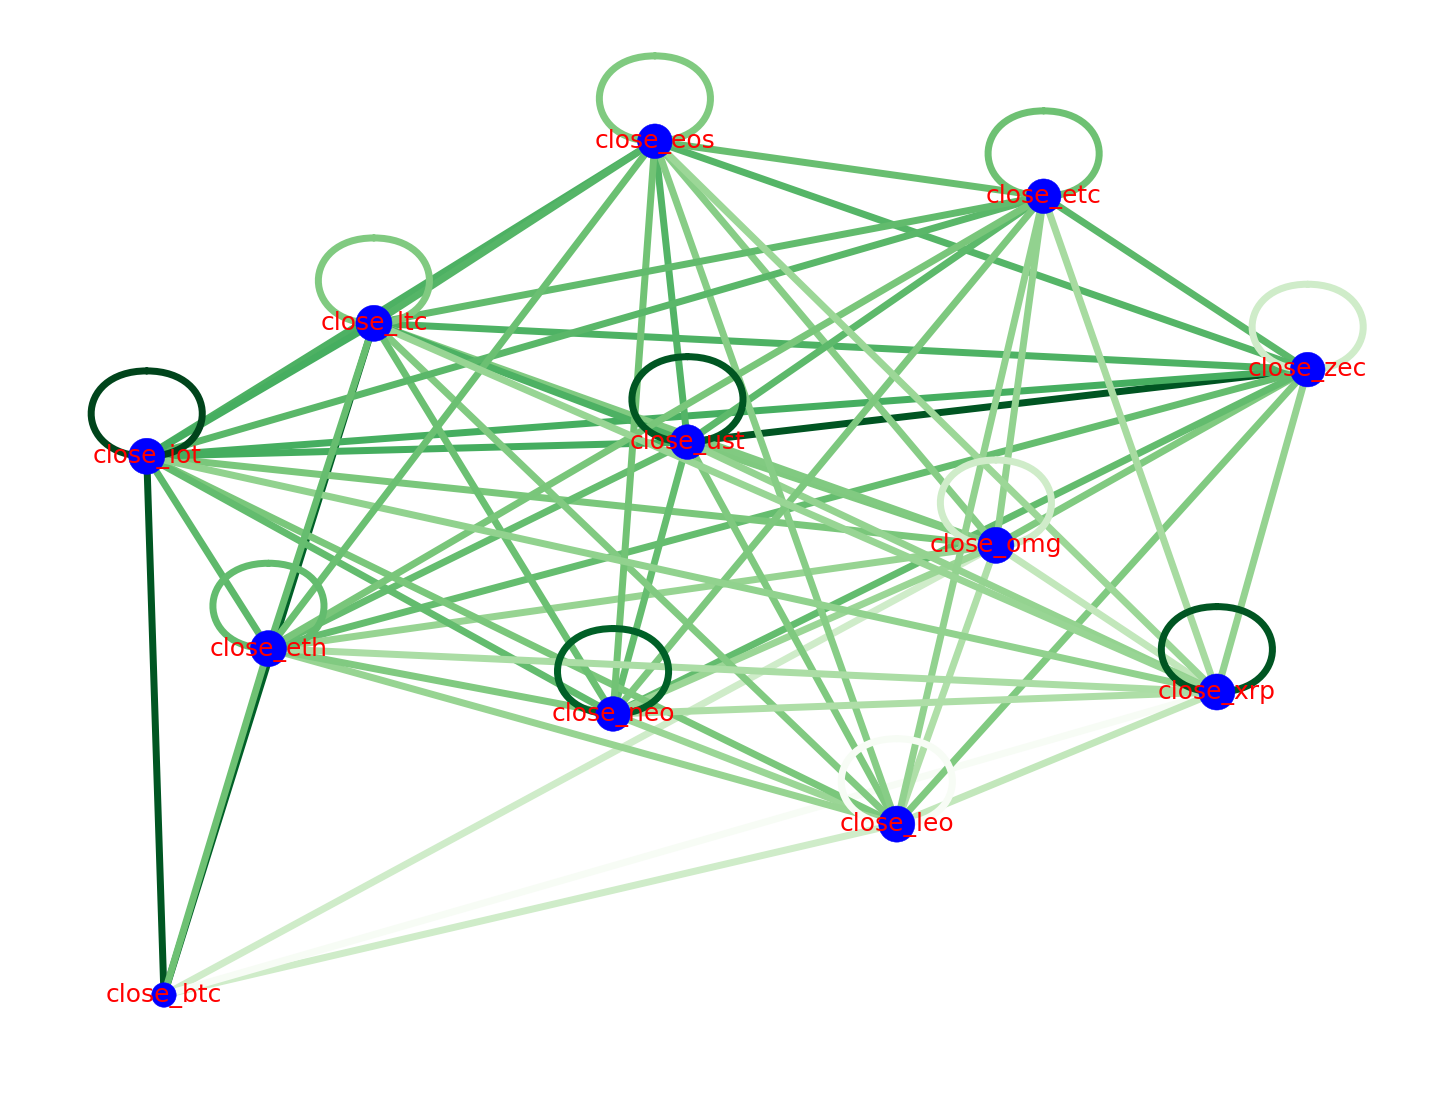

In [44]:
plt.figure(figsize=(17, 12))
coord=nx.spring_layout(G_copy)
labels = data_normalized.columns.values
G_copy = nx.relabel_nodes(G_copy, dict(zip(range(len(labels)), labels)))
print('Disparity filter')
draw_network(G_copy)

#Trading

In [45]:
data_for_strategy = data[['close_btc', 'close_zec', 'close_ust']]
test_data = data_for_strategy.iloc[round(len(data_for_strategy)*0.90):, :]
valid_data = data_for_strategy.iloc[round(len(data_for_strategy)*0.80):round(len(data_for_strategy)*0.90)-1, :]
test_data

,close_btc,close_zec,close_ust
85599,37224.00000,101.29,1.00130
85600,37008.00000,100.93,1.00130
85601,37000.00000,100.62,1.00130
85602,37020.84089,100.56,1.00130
85603,37063.00000,100.53,1.00130
...,...,...,...
95105,29417.00000,103.32,0.99975
95106,29358.00000,103.32,0.99974
95107,29328.00000,102.99,0.99973
95108,29253.00000,102.42,0.99972


In [46]:
def compose_pairs(df):
    pairs = list()
    tested_pairs = list()
    for smpl in df.columns:
        for smpl2 in df.columns:
            if smpl != smpl2 and (smpl2, smpl) not in tested_pairs:
              pairs.append([df[smpl], df[smpl2]])
              tested_pairs.append((smpl, smpl2))
    print('There are {} pairs'.format(len(pairs)))
    return pairs, tested_pairs

In [47]:
pair_data, composed = compose_pairs(valid_data[-1000:]) #compose pairs
composed

There are 3 pairs


[('close_btc', 'close_zec'),
 ('close_btc', 'close_ust'),
 ('close_zec', 'close_ust')]

In [48]:
!pip install statsmodels
from statsmodels.tsa.arima_model import ARIMA

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [49]:
def trade(a_sh, a_lo, window, account, next_df, previous_df, name1, name2, mode = 'none'):
    """ Simulation of trade with sliding window for 1 pair. Calculates returns, portfolio value, and invested capital"""
    portfolio_value_list = []
    acc_return_list = []
    cap_invested = []
    commission = 0.001
    stock1 = 0
    stock2 = 0
    acc_return = 0.0
    prev_capital = 0.0
    prev_price1 = 0.0
    prev_price2 = 0.0
    prev_stock1 = 0
    prev_stock2 = 0
    start_idx = 0
    trade_indicator = 'no_trade'
    portfolio_value = 0
    end_idx = start_idx + window + 1 #last observation is not included
    resid = 0.0
    full_df = pd.concat([previous_df.iloc[-window:,:], next_df], axis = 0)
    while end_idx <= full_df.shape[0] - 1:
        p1 = full_df[name1][start_idx:end_idx]
        p2 = full_df[name2][start_idx:end_idx]
        spread = p1 - p2
        spread_ds = ForecastDataset(spread.values, window_size=args.window_size, horizon=3,
                            normalize_method=args.norm_method, norm_statistic=normalize_statistic)
        spread_loader = torch.utils.data.DataLoader(spread_ds, batch_size=len(spread_ds), shuffle=False, num_workers=0)
        if mode == 'neural':
          with torch.no_grad():
            for  inputs, targets in spread_loader:
              inputs = inputs.to(args.device)
              pred, _ = model(inputs)
          pred = pred.cpu().numpy()[-1][0][-1]
          pred_chg = (pred - spread[-1:] / spread[-1:])
          pred_chg = np.array(pred_chg)[0]
          price1 = np.array(p1[-1:])[0]
          price2 = np.array(p2[-1:])[0]
        elif mode == 'arima':
          try:
            arma = ARIMA(np.array(spread), order = (1,0,1)).fit()
            pred = arma.forecast(steps=1, exog=None, alpha=0.01)[0][0]
            pred_chg = (pred - spread[-1:] / spread[-1:])     
            pred_chg = np.array(pred_chg)[0]
            price1 = np.array(p1[-1:])[0]
            price2 = np.array(p2[-1:])[0]
          except:
            pass
        
        portfolio_value = resid + stock1 * price1 + stock2 * price2 #portfolio revaluation 
        portfolio_value_list.append(portfolio_value)
        if price1 != 0 and price2 != 0: #if stock was traded
            if trade_indicator == 'short':
                acc_return += ((prev_price1 - price1)*prev_stock1 + (price2 - prev_price2)*prev_stock2) / prev_capital
            elif trade_indicator == 'long':
                acc_return += (prev_price2 - price2)*prev_stock2 + (price1 - prev_price1)*prev_price1 / prev_capital
            acc_return_list.append(acc_return)
            
            if pred_chg <= a_sh:
                trade_indicator = 'short'
                deal1 = stock1 * price1 * (1 - commission) #sell stock1
                if stock1 != 0:
                    prev_stock1 = stock1
                if deal1 > allocated_capital: 
                    stock1_to_sell = allocated_capital // (price1 * (1 - commission))
                    deal1 = stock1_to_sell * price1 * (1 - commission)
                    stock1 -= stock1_to_sell
                    if stock1_to_sell != 0:
                        prev_stock1 = stock1_to_sell
                else:
                    stock1 = 0
                account += deal1
                stock_2_bought = account // (price2 * (1 + commission))
                deal2 = stock_2_bought * price2 * (1 + commission) #buy stock2
                if deal2 > allocated_capital:
                    stock_2_bought = allocated_capital // (price2 * (1 + commission))
                    deal2 = stock_2_bought * price2 * (1 + commission)
                account -= deal2
                resid = account
                stock2 += stock_2_bought

                if deal1+deal2 != 0:
                    prev_capital = deal1+deal2
                    cap_invested.append(prev_capital)
                if stock_2_bought != 0:
                    prev_stock2 = stock_2_bought

            elif pred_chg >= a_lo:
                trade_indicator = 'long'
                deal2 = stock2 * price2 * (1 - commission) #sell stock2
                if stock2 != 0:
                    prev_stock2 = stock2
                if deal2 > allocated_capital:
                    stock2_to_sell = allocated_capital // (price2 * (1 - commission))
                    deal2 = stock2_to_sell * price2 * (1 - commission)
                    stock2 -= stock2_to_sell
                    if stock2_to_sell != 0:
                        prev_stock2 = stock2_to_sell
                else:
                    stock2 = 0
                account += deal2
                stock_1_bought = account // (price1 * (1 + commission))
                deal1 = stock_1_bought * price1 * (1 + commission) #buy stock1
                if deal1 > allocated_capital:
                    stock_1_bought = allocated_capital // (price1 * (1 + commission))
                    deal1 = stock_1_bought * price1 * (1 + commission)
                account -= deal1
                resid = account
                stock1 += stock_1_bought
                if deal1+deal2 != 0:
                    prev_capital = deal1+deal2
                    cap_invested.append(prev_capital)
                if stock_1_bought != 0:
                    prev_stock1 = stock_1_bought

            prev_price1 = price1
            prev_price2 = price2
            
        start_idx += 1
        end_idx += 1
        
    portfolio_value_list[0] = allocated_capital
    return acc_return_list, portfolio_value_list, cap_invested

def calc_returns(val_port_value, allocated_capital):
    """Calculates returns on capital invested"""
    total_returns = []
    for p in val_port_value:
            total_returns.append((p - allocated_capital) * 100 / allocated_capital)
            total_returns[0] = 0 #because at index 0 there has not been any return yet
    return total_returns 
    

In [50]:
 def spread_change(spread):
    spread_chg = (spread.shift(-1) - spread)[:-1]
    spread_chg = spread_chg / spread[:-1]
    return spread_chg

In [51]:
from statistics import mean

def find_thresholds(pairs,price_train,  price_val, prev_df, window, allocated_capital, mode = 'none'):
    """Calculates profitability of each pair and finds optimal thresholds"""
    chosen_params = []
    cv_profit = []

    for pair_num in range(len(pairs)):
        name1 = pairs[pair_num][0].name
        name2 = pairs[pair_num][1].name
        spread = price_train.loc[:, name1] - price_train.loc[:, name2]
        spread_chg = spread_change(spread)
        quantiles = np.quantile(spread_chg, [0.2, 0.8], interpolation = 'linear')
        deciles = np.quantile(spread_chg, [0.1, 0.9], interpolation = 'linear')

        cv_thresh_res = []
        for thresh in [quantiles]:
            val_returns, val_port_value, cap_inv = trade(thresh[0], thresh[1], window, allocated_capital,  price_val, prev_df, name1, name2, mode) 
            total_returns = calc_returns(val_port_value, allocated_capital)
            cv_thresh_res.append(mean(total_returns)) 
            
        best_thresh = cv_thresh_res.index(max(cv_thresh_res))
        if best_thresh == 0:
            chosen_params.append(pd.Series(quantiles,name = pairs[pair_num][0].name + '-' + pairs[pair_num][1].name))
        else:
            chosen_params.append(pd.Series(deciles, name = pairs[pair_num][0].name + '-' + pairs[pair_num][1].name))
        max_profit =  max(cv_thresh_res)
        cv_profit.append(pd.Series(max_profit, name = pairs[pair_num][0].name + '-' + pairs[pair_num][1].name))
    return cv_profit, chosen_params

In [52]:
allocated_capital = 1000000 
crypto_profit, crypto_chosen_params = find_thresholds(pair_data, valid_data.iloc[-1000:, :], test_data.iloc[:1000, :], valid_data.iloc[-1000:, :], 20, allocated_capital, mode='neural')

/content/StemGNN/models/base_model.py:49: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  ffted = torch.rfft(input, 1, onesided=False)
/content/StemGNN/models/base_model.py:58: UserWarning: The function torch.irfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.irfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:602.)
  iffted = torch.irfft(time_step_as_inner, 1, onesided=False)


In [53]:
arima_profit, arima_chosen_params = find_thresholds(pair_data, valid_data.iloc[-1000:, :], test_data.iloc[:1000, :], valid_data.iloc[-1000:, :], 750, allocated_capital, mode='arima')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:221: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelih

In [54]:
def find_best_pairs(cv_profit):
    """Finds profitable and unprofitable pairs, keeps the former"""
    profitable = 0
    unprofitable = 0
    profitable_pairs = []
    value = []
    name = []
    for num, trade in enumerate(cv_profit):
        indicator = 0
        trade_names = trade.name.split('-')
        for sec_trade in cv_profit[num + 1:]: #check pairs do not repeat
            sec_trade_name = sec_trade.name.split('-')
            if trade_names[0] in sec_trade_name and trade_names[1] in sec_trade_name:
                indicator += 1
        if indicator == 0:
            if trade[0]> 0: 
                profitable += 1
                value.append(trade[0])
                name.append(trade.name)
            else: 
                unprofitable += 1
    print('There are {} profitable and {} unprofitable pairs'.format(profitable, unprofitable)) 
    print('These ones are profitable')

    df_profit_pairs = pd.DataFrame([value, name]).transpose()
    df_profit_pairs.columns = ['return', 'pair']
    df_profit_pairs.sort_values(by = 'return', inplace = True, ascending = False)
    return df_profit_pairs

In [55]:
crypto_profit_pairs = find_best_pairs(crypto_profit)
crypto_profit_pairs.head(10)

There are 0 profitable and 3 unprofitable pairs
These ones are profitable


,return,pair


In [56]:
crypto_profit #returns

[0   -1.207357
 Name: close_btc-close_zec, dtype: float64, 0   -0.106182
 Name: close_btc-close_ust, dtype: float64, 0   -0.106182
 Name: close_zec-close_ust, dtype: float64]

In [57]:
arima_profit_pairs = find_best_pairs(arima_profit)
arima_profit_pairs.head(10)

There are 2 profitable and 1 unprofitable pairs
These ones are profitable


,return,pair
0,1.006525,close_btc-close_zec
1,1.006525,close_btc-close_ust


In [58]:
arima_profit #returns

[0    1.006525
 Name: close_btc-close_zec, dtype: float64, 0    1.006525
 Name: close_btc-close_ust, dtype: float64, 0   -1.185927
 Name: close_zec-close_ust, dtype: float64]

In [59]:
def choose_from_best(number_of_pairs, df_profit_pairs, chosen_params):
    """Choose N best pairs"""
    if number_of_pairs > df_profit_pairs.shape[0]:
        print('There are less than {} pairs available'.format(number_of_pairs))
        number_of_pairs = df_profit_pairs.shape[0]
    chosen_pairs = df_profit_pairs.iloc[:number_of_pairs, :]
    print('These pairs chosen are:')
    print(chosen_pairs)
    
    quantiles_chosen = []
    for pair in chosen_pairs.pair:
        for q in chosen_params:
            if q.name == pair:
                quantiles_chosen.append(np.array(q))
    return chosen_pairs, quantiles_chosen
    

In [60]:
crypto_chosen_pairs, crypto_quantiles = choose_from_best(3, crypto_profit_pairs, crypto_chosen_params)

There are less than 3 pairs available
These pairs chosen are:
Empty DataFrame
Columns: [return, pair]
Index: []


In [61]:
arima_chosen_pairs, arima_quantiles = choose_from_best(3, arima_profit_pairs, arima_chosen_params)

There are less than 3 pairs available
These pairs chosen are:
     return                 pair
0  1.006525  close_btc-close_zec
1  1.006525  close_btc-close_ust
